In [ ]:
!pip install -U scikit-learn tensorflow

# 0. Reference

1. [SKLearn Documentation](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

2. [How to Calculate Feature Importance With Python
](https://machinelearningmastery.com/calculate-feature-importance-with-python/)


3. [Independence, Covariance and Correlation between two Random Variables](https://towardsdatascience.com/independence-covariance-and-correlation-between-two-random-variables-197022116f93)
    * Covariance is the measure of the joint variability of two random variables
    * Correlation is just a scaled/normalised version of covariance so that the values lie between -1 to 1

4. Mutual Information Gain
    * [Video introduction to mutual information
](https://www.youtube.com/watch?v=U9h1xkNELvY)
    * [Information Gain and Mutual Information for Machine Learning](https://machinelearningmastery.com/information-gain-and-mutual-information/)
    * Reduction in entropy or surprise by transforming a dataset and is often used in training decision trees.
    * Mutual information calculates the statistical dependence between two variables and is the name given to information gain when applied to variable selection.
    * Entropy = -(p(0) * log(P(0)) + p(1) * log(P(1)))

5. [Techniques of Feature Engineering](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114)

# 1. Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import (
    SelectKBest, chi2, f_classif, SequentialFeatureSelector,mutual_info_classif,
    SelectFromModel, RFECV, RFE
)
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/A-s-m-a/Mobile-Price-Classification/main/train.csv')
X = df.iloc[:, 0 : -1]
y = df.iloc[:, -1]
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


# 2. Feature Selection

## 2.1 Select Kbest (Chi Square)

Chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.

[Pearson’s chi-squared test from scratch](https://medium.com/analytics-vidhya/pearsons-chi-squared-test-from-scratch-with-python-ba9e14d336c)

In [ ]:
# SelectKBest class to extract top 10 best features
# bestfeatures = SelectKBest(score_func=chi2, k=10)
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score'] # naming the dataframe columns
print(featureScores.nlargest(10, 'Score')) # print 10 best features

            Specs     Score
13            ram  0.847633
0   battery_power  0.032003
12       px_width  0.028139
5          four_g  0.023691
11      px_height  0.022790
8       mobile_wt  0.017015
17        three_g  0.015666
19           wifi  0.012429
2     clock_speed  0.010963
14           sc_h  0.009294


## 2.2 Recursive feature elimination

The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute (such as coef_, feature_importances_). Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Note: Choice of input variables can be seen via the “support_” attribute that provides a True or False for each input variable. You can use RFECV to automatically select the Number of Features
```python
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
RFECV(estimator=model, step=1, cv=cv)

# regression
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
# lr
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
# perceptron
rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
# cart
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
# rf
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
# gbm
rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)

```

In [ ]:
# eliminate one feature with lowest coef/feature importance every iteration
model = GradientBoostingClassifier()
rfe = RFE(estimator=model, n_features_to_select=3, step=1)
rfe.fit(X, y)
df = pd.DataFrame({'Features': X.columns, "Support": rfe.support_, "Ranking":rfe.ranking_})
df.sort_values('Ranking').head(5)

,Features,Support,Ranking
0,battery_power,True,1
13,ram,True,1
11,px_height,True,1
12,px_width,False,2
8,mobile_wt,False,3


## 2.3. Select from Tree Based Model

Random forest uses bootstrap replicas, that is to say, it subsamples the input data with replacement, whereas Extra Trees use the whole original sample. In the Extra Trees sklearn implementation there is an optional parameter that allows users to bootstrap replicas, but by default, it uses the entire input sample. This may increase variance because bootstrapping makes it more diversified. Another difference is the selection of cut points in order to split nodes. Random Forest chooses the optimum split while Extra Trees chooses it randomly. However, once the split points are selected, the two algorithms choose the best one between all the subset of features. Therefore, Extra Trees adds randomization but still has optimization.


Feature importance(Tree Based) is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.

This approach applicable to TreeBased (feature importance) & Regression (coef)

[0.06026731 0.02013249 0.03325304 0.01986165 0.03201047 0.01714523
 0.03637516 0.03456975 0.03701849 0.03428025 0.03456379 0.04838101
 0.04844599 0.38299658 0.03475558 0.03541874 0.0362644  0.01462359
 0.01849593 0.02114055]


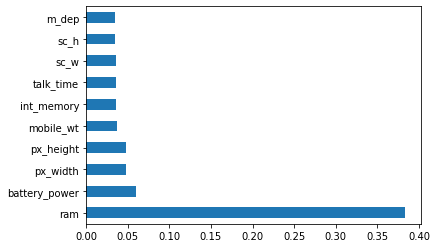

In [ ]:
# ensemble tree base
clf = ExtraTreesClassifier()
clf.fit(X, y)
print(clf.feature_importances_)
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

## 2.4 Permutation Feature Importance

Suits the models which doesn't provide feature importance score. It scrambled the values of a feature to find the importance score (baseline - permutated performance)

The permutation importance of a feature is calculated as follows. First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

In [ ]:
model = KNeighborsClassifier()
model.fit(X, y)
results = permutation_importance(model, X.values, y.values, scoring='accuracy', max_samples=0.5, n_repeats=5)
print(results.importances_mean)
pd.DataFrame({'FeatureName': X.columns, "ImportanceScore": results.importances_mean}).sort_values('ImportanceScore', ascending=False).head(5)

[ 0.2038 -0.004  -0.004  -0.004  -0.004  -0.004  -0.0034 -0.004  -0.002
 -0.004  -0.004   0.0846  0.0888  0.6862 -0.004  -0.004  -0.004  -0.004
 -0.004  -0.004 ]


,FeatureName,ImportanceScore
13,ram,0.6862
0,battery_power,0.2038
12,px_width,0.0888
11,px_height,0.0846
8,mobile_wt,-0.0020


## 2.5 Sequential Feature Selection

Fundamentally differes from RFE, it does not require the underlying model to expose a **coef_** or **feature_importances_** attribute

This Sequential Feature Selector adds (forward selection) or removes (backward selection) features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [ ]:
# start with 1 feature and increase
clf = ExtraTreesClassifier()
clf.fit(X, y)

sfs_forward = SequentialFeatureSelector(
    clf, n_features_to_select=2, direction='forward').fit(X, y)

# start with max feature and decrease
sfs_backward = SequentialFeatureSelector(
    clf, n_features_to_select=2, direction='backward').fit(X, y)

print("Features selected by forward sequential selection: "
      f"{X.columns[sfs_forward.get_support()]}")
print("Features selected by backward sequential selection: "
      f"{X.columns[sfs_backward.get_support()]}")

Features selected by forward sequential selection: Index(['battery_power', 'ram'], dtype='object')
Features selected by backward sequential selection: Index(['battery_power', 'ram'], dtype='object')


## 2.6 Correlation Heatmap

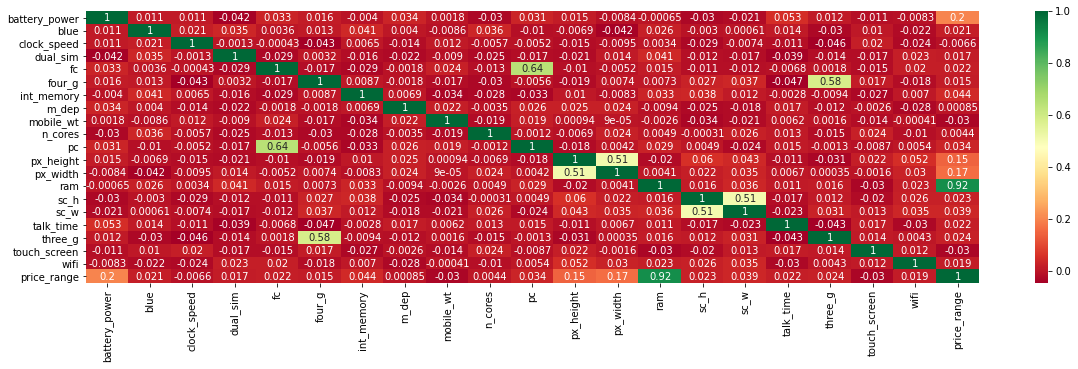

In [ ]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,5))
g = sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="RdYlGn")

## 2.7 Auto Encoder

The aim of an autoencoder is to learn a lower-dimensional representation (encoding) for a higher-dimensional data, typically for dimensionality reduction, by training the network to capture the most important parts of the input image.

[What is AutoEncoder](https://www.v7labs.com/blog/autoencoders-guide) [Python](https://machinelearningmastery.com/autoencoder-for-classification/)

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model

### Data Processing
X, y = make_classification(
    n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
n_inputs = X.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

### Data Scaling
t = MinMaxScaler()
X_train = t.fit_transform(X_train)
X_test = t.transform(X_test)

### define auto encoder model
visible = Input(shape=(n_inputs,))

# encoder layer
e = Dense(n_inputs * 2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck - reduce 50%
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(e)

# decoder layer
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
output = Dense(n_inputs, activation='linear')(d)

model = Model(inputs=visible, outputs=output)
model.compile(optimizer='adam', loss='mse')
# plot_model(model, 'autoencoder_compress.png', show_shapes=True)
history = model.fit(
    X_train, X_train, epochs=100, batch_size=16, verbose=2, validation_data=(X_test,X_test)
)

# save an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
encoder.save('encoder.h5')

Epoch 1/100
42/42 - 2s - loss: 0.2088 - val_loss: 0.1571 - 2s/epoch - 53ms/step
Epoch 2/100
42/42 - 0s - loss: 0.0315 - val_loss: 0.0912 - 484ms/epoch - 12ms/step
Epoch 3/100
42/42 - 0s - loss: 0.0210 - val_loss: 0.0500 - 394ms/epoch - 9ms/step
Epoch 4/100
42/42 - 0s - loss: 0.0174 - val_loss: 0.0276 - 398ms/epoch - 9ms/step
Epoch 5/100
42/42 - 0s - loss: 0.0147 - val_loss: 0.0174 - 219ms/epoch - 5ms/step
Epoch 6/100
42/42 - 0s - loss: 0.0134 - val_loss: 0.0131 - 250ms/epoch - 6ms/step
Epoch 7/100
42/42 - 0s - loss: 0.0124 - val_loss: 0.0104 - 260ms/epoch - 6ms/step
Epoch 8/100
42/42 - 0s - loss: 0.0116 - val_loss: 0.0083 - 224ms/epoch - 5ms/step
Epoch 9/100
42/42 - 0s - loss: 0.0107 - val_loss: 0.0075 - 267ms/epoch - 6ms/step
Epoch 10/100
42/42 - 0s - loss: 0.0103 - val_loss: 0.0066 - 228ms/epoch - 5ms/step
Epoch 11/100
42/42 - 0s - loss: 0.0094 - val_loss: 0.0062 - 241ms/epoch - 6ms/step
Epoch 12/100
42/42 - 0s - loss: 0.0113 - val_loss: 0.0071 - 227ms/epoch - 5ms/step
Epoch 13/100
4

In [ ]:
### loading the encoder model
encoder = load_model('encoder.h5')

# encode the data for feature selection
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)

print('Before Encoding', X_train.shape)
print('After Encoding', X_train_encode.shape)

# predict without encoder
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
print('Without Encoder', accuracy_score(y_test, yhat))

# predict without encoder
model = LogisticRegression(max_iter=1000)
model.fit(X_train_encode, y_train)
yhat = model.predict(X_test_encode)
print('With Encoder', accuracy_score(y_test, yhat))

11/11 [==============================] - 0s 5ms/step
Before Encoding (670, 100)
After Encoding (670, 50)
Without Encoder 0.8939393939393939
With Encoder 0.9303030303030303
